### ReAct Agent Architecture

#### Aim
This is the intuition behind ReAct, a general agent architecture.

1. act - let the model call specific tools
2. observe - pass the tool output back to the model
3. reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [4]:
wiki.invoke("What is AGI?")

'Page: Artificial general intelligence\nSummary: Artificial general intelligence (AGI)—sometimes called human‑level AI—is a hypothetical type of artificial intelligence that would match or surpass human capabilities across virtually all cognitive tasks.\nBeyond AGI, artificial superintelligence (ASI) would outperform the best human abilities across every domain by a wide margin. Unlike artificial narrow intelligence (ANI), whose competence is confined to well‑defined tasks, an AGI system can genera'

In [5]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"]="ReAct-agent"


In [6]:
### Custom Functions
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[arxiv,wiki,add,multiply,divide]

In [7]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\rajpu\AppData\Local\Temp\ipykernel_24644\3584238.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [8]:
tavily.invoke("Provide me the recent AI news for march 3rd 2025")

[{'title': 'AI Daily News March 03 2025: …–AI Unraveled: Latest AI News ...',
  'url': 'https://podcasts.apple.com/ca/podcast/ai-daily-news-march-03-2025-nvidia-ceo-us-ai-chips/id1684415169?i=1000697521476',
  'content': "AI Unraveled: Latest AI News & Trends, ChatGPT, Gemini, DeepSeek, Gen AI, LLMs, Agents, Ethics, Bias\n\n# AI Daily News March 03 2025: 🚀 Nvidia CEO: US AI Chips Are 60x Faster Than China’s 🍏Apple's Siri Overhaul Facing Major Delays 🎙️New AI Voice to Cross ‘Uncanny Valley’ 🎥Sora Video AI Coming to ChatGPT 🧪AI Detects Colorect [...] Nvidia claims a significant lead in AI chip speed over China, while Apple faces delays in its Siri AI overhaul. New AI applications are emerging, including highly realistic voice generation, automated resume screening, and AI cardiologists in China.OpenAI plans to integrate Sora video AI into ChatGPT, and large investments are being made in AI by companies like Honor and SoftBank. AI is also showing promise in healthcare with tools for cance

In [9]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily,add,divide,multiply]

In [10]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen/qwen3-32b")
response = llm.invoke("Write a code for binary search in c++")

In [11]:
response

AIMessage(content='<think>\nOkay, the user wants me to write a C++ code for binary search. Let me think about how to approach this. Binary search is an efficient algorithm for finding an item in a sorted list. It works by repeatedly dividing the search interval in half. \n\nFirst, I need to decide whether to implement the iterative or recursive version. Since recursion can lead to stack overflow for large data, maybe the iterative approach is better here. Plus, it\'s generally more efficient in terms of space.\n\nThe function should take a sorted array, a target value, and the size of the array. Wait, in C++, arrays are passed as pointers, so the function needs the size as a parameter. The function should return the index of the target if found, otherwise -1.\n\nLet me outline the steps for binary search:\n\n1. Initialize low as 0 and high as size - 1.\n2. While low is less than or equal to high:\n   a. Calculate mid as the average of low and high. But wait, using (low + high)/2 can ca

In [12]:
llm_with_tools = llm.bind_tools(tools)

In [13]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002D26D096000>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002D26D2D3470>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'arxiv', 'description': 'A wrapper around Arxiv.org Useful for when you need to answer questions about Physics, Mathematics, Computer Science, Quantitative Biology, Quantitative Finance, Statistics, Electrical Engineering, and Economics from scientific articles on arxiv.org. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'wikipedia', 'description': 'A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts,

In [14]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. I need to figure out which tool to use here. Let me check the available functions.\n\nThe tools provided include arxiv, wikipedia, tavily_search_results_json, add, divide, multiply. The user\'s query is about recent news, so the tavily_search_results_json seems appropriate because it\'s optimized for current events. Arxiv is for scientific papers, and wikipedia might not have the most up-to-date news. The mathematical functions don\'t apply here. So I\'ll use tavily_search_results_json with the query "recent AI news" to get the latest information.\n', 'tool_calls': [{'id': '2y1bs4nfn', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 156, 'prompt_tokens': 637, 'total_tokens': 793, 'completion_time': 0.260458183, 'prompt_time': 0.029169323, 'queue_time': 0.1

In [15]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI News'},
  'id': 'fj72j15pk',
  'type': 'tool_call'}]

In [16]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

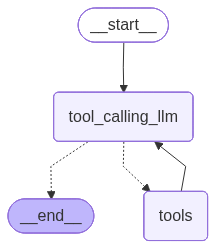

In [17]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for MArch 3rd 2025,add 5 plus 5 and then multiply by 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for MArch 3rd 2025,add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (2v5r1vw63)
 Call ID: 2v5r1vw63
  Args:
    query: top 10 AI news March 3rd 2025
  add (9bjnxtz9h)
 Call ID: 9bjnxtz9h
  Args:
    a: 5
    b: 5
  multiply (jsswcb4wc)
 Call ID: jsswcb4wc
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The top 10 AI stories of 2025 - CIO", "url": "https://www.cio.com/article/4109202/the-top-10-ai-stories-of-2025.html", "content": "enthusiasts. [...] its technology platforms, and something that’s earned the company a 2025 CIO 100 Award in IT Excellence. [...] It’s safe to say that AI was _the_ story of 2025: It topped CIOs’ tech agendas; vendors rolled out 

#### MemorySaver
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [19]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")

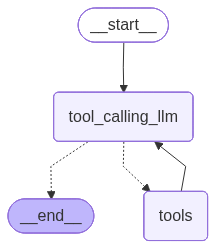

In [20]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
## Specify the thread

config = {"configurable":{"thread_id":"1"}}

## Specify an Input
messages = [HumanMessage(content="Add 4 and 5")]

messages=graph_memory.invoke({"messages":messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 4 and 5
================================== Ai Message ==================================
Tool Calls:
  add (8bezm75s6)
 Call ID: 8bezm75s6
  Args:
    a: 4
    b: 5
================================= Tool Message =================================
Name: add

9
================================== Ai Message ==================================

The sum of 4 and 5 is **9**.


In [22]:
## Specify an Input
messages = [HumanMessage(content="add that number to 60")]

messages=graph_memory.invoke({"messages":messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 4 and 5
================================== Ai Message ==================================
Tool Calls:
  add (8bezm75s6)
 Call ID: 8bezm75s6
  Args:
    a: 4
    b: 5
================================= Tool Message =================================
Name: add

9
================================== Ai Message ==================================

The sum of 4 and 5 is **9**.
================================ Human Message =================================

add that number to 60
================================== Ai Message ==================================
Tool Calls:
  add (fxvav0rgw)
 Call ID: fxvav0rgw
  Args:
    a: 9
    b: 60
================================= Tool Message =================================
Name: add

69
================================== Ai Message ==================================

69

The final result is $\boxed{69}$.


In [23]:
## Specify an Input
messages = [HumanMessage(content="multiply the number by 24")]

messages=graph_memory.invoke({"messages":messages}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 4 and 5
================================== Ai Message ==================================
Tool Calls:
  add (8bezm75s6)
 Call ID: 8bezm75s6
  Args:
    a: 4
    b: 5
================================= Tool Message =================================
Name: add

9
================================== Ai Message ==================================

The sum of 4 and 5 is **9**.
================================ Human Message =================================

add that number to 60
================================== Ai Message ==================================
Tool Calls:
  add (fxvav0rgw)
 Call ID: fxvav0rgw
  Args:
    a: 9
    b: 60
================================= Tool Message =================================
Name: add

69
================================== Ai Message ==================================

69

The final result is $\boxed{69}$.
================================ Human Message ====================